# load data 

In [1]:
def splitTolenWords(text, nwords):
    words = text.split(" ")
    count = int(len(words)/nwords)
    sentences = [" ".join(words[(i*nwords):((i+1)*nwords)]) for i in range(count)]
    return(sentences)

In [2]:
with open("data_splits/trumpGeneratorTextTrain.txt", encoding = "utf-8") as f:
    gentrain = f.read()
    
with open("data_splits/trumpGeneratorTextValid.txt", encoding = "utf-8") as f:
    genvalid = splitTolenWords(f.read(), 100)

# load gpt-2 tokenizer 

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokens = tokenizer(gentrain)["input_ids"]

Token indices sequence length is longer than the specified maximum sequence length for this model (351805 > 1024). Running this sequence through the model will result in indexing errors


# create token - word relations 

In [4]:
import pandas as pd

def formdb(tokens, ngrams):
    grams = pd.DataFrame()
    n = 2
    for i in range(len(tokens) - n):
        i = tokens[i:i+n]

    grams = [tokens[i:i+n] for i in range(len(tokens) - n)]
    grams_mem = pd.DataFrame(grams)
    return grams_mem

In [5]:
grams_mem = formdb(tokens, 2)

# create function to sample sequences 

In [6]:
import numpy as np

def filter_db(db, tokens, iteration = 0):
    n = db.shape[1]
    tokens = tokens[-n:]
    filt = db
    for i in range(n-1 - iteration):
        filt= filt[filt[i+iteration]==tokens[i+iteration]]
    return(filt)

def temperature(dat, temp = 1):
    res = np.exp(dat*temp)
    return res/res.sum()

def top_k(dat, k = 0):
    if k == 0: 
        return dat
    else:
        return dat[:(k)]
    
def top_p(dattemp, p = 1):
    sump = 0
    #print(len(dattemp))
    for i in range(len(dattemp)):
        sump += dattemp.iloc[i]
        if sump > p:
            break

    res = dattemp[:(i+1)]
    res = res/sum(res)
    return res


def sample(tokens, db, temp = 1, k = 0, p = 1):
    n = db.shape[1]
    for i in range(n-1):
        dat = filter_db(db, tokens, i)[n-1].value_counts(normalize = True)
        if len(dat) != 0 :
            dat = temperature(dat,temp)  
            dat = top_k(dat,k)
            dat = top_p(dat,p)
            word = dat.to_frame().sample(weights = dat.to_frame()[n-1]).index[0]
            break
    if len(dat) == 0:
        dat = db[n-1].value_counts(normalize = True)
        #print(dat)
        word = dat.to_frame().sample(weights = dat.to_frame()[n-1]).index[0]
        #print(word)
    return(word)

In [7]:
def generator(db, ntokens, context_str, temp = 0.7, k = 5, p = 0.6):
    ls = tokenizer(context_str)["input_ids"]
    for i in range(ntokens):
        ls.append(sample(ls, db, temp = temp, k = k, p = p))
    return(tokenizer.decode(ls))

In [8]:
context = "something just happened"
len(generator(grams_mem, 130, context).split(" "))

104

# load metrics 

In [14]:
import spacy
import en_core_web_sm
from nltk.translate.bleu_score import sentence_bleu
from scipy.stats import ttest_ind

def unnameTextWithM(text):
    nlp = en_core_web_sm.load()
    doc = nlp(text)
    text = text
    for ent in reversed(doc.ents):
        text = text[:ent.start_char] + "<M>" + text[ent.end_char:] 
    return text

def bleu_scores(string, valid_data):
    valid = [i.split(" ") for i in valid_data]
    string = string.split(" ")[:100]
    bleu1 = sentence_bleu(valid, string ,weights = (0.25,0.25,0.25,0.25))
    return (bleu1)


In [10]:
import dill as pickle
pickle._dill._reverse_typemap['ClassType'] = type

objectRep = open("classifiers/POSclassifier4.obj", "rb")
POSclassiefier = pickle.load(objectRep)
objectRep.close()
 
objectRep = open("classifiers/Textclassifier.obj", "rb")
Textclassifier = pickle.load(objectRep)
objectRep.close()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import en_core_web_sm

Posclassifier = POSclassiefier()
Posclassifier.predict(["testing methos to predict something"])

array([[0.27068743, 0.72931254]], dtype=float32)

In [12]:
Textclassifier.predict_proba(['something just happened want in you this, country and and we the\'re United not States even is though the you way know it that was, going " to And be we a have little to bit be. the the United history was of going our to history the,'])[:,1][0]

0.6276698226575678

In [13]:
import random
def randcontext(text,lensen):
    gentrainwords = text.split(" ")
    ran = len(gentrainwords)-lensen
    x = random.randint(0,ran)
    text = " ".join(gentrainwords[x:(x+lensen)])
    return text

In [15]:
def evaluate(genvalid, genstr):
    strM = unnameTextWithM(genstr)
    b = bleu_scores(strM, genvalid)
    Tscore = Textclassifier.predict_proba([strM])[0,1]
    Posscore= Posclassifier.predict([strM])[0,1]
    return (b,Tscore,Posscore)

# gridsearch params on validation dataset

In [17]:
import tqdm
bar = tqdm.tqdm(total = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
bar.update(1)
bar.reset()


(6.7938478551239e-155, 1.0, 0.8056452):   0%|          | 0/320 [00:00<?, ?it/s]          

In [ ]:
ngrams = [2,3,4,5]
temp = [0.2,0.4,0.6,0.8,1]
k = [5,10,20,50]
p = [0.2,0.6,0.8,1.0]

results = []

bar = tqdm.tqdm(total = len(ngrams)* len(temp) * len(k) * len(p))
for n in ngrams:
    for t in temp:
        for ki in k:
            for pi in p:
                #print(n,t,ki,pi)
                grams_mem = formdb(tokens, n)
                for i in range(10):
                    context = randcontext(gentrain,10)
                    strM = unnameTextWithM(generator(grams_mem, 130, context, temp = t, k = ki, p = pi))
                    b1 = bleu_scores(strM, genvalid)
                    Tscore = Textclassifier.predict_proba([strM])[0,1]
                    Posscore= Posclassifier.predict([strM])[0,1]
                    results.append((((n,t,ki,pi),)+(b1,Tscore,Posscore)))
                bar.update(1)

 57%|█████▋    | 181/320 [40:27<34:04, 14.71s/it] 

In [26]:
results

[((2, 0.2, 1, 0.2),
  (0.66,
   0.2727272727272727,
   2.2250738585072626e-308,
   2.2250738585072626e-308,
   0.9997833129036022,
   0.073108636)),
 ((2, 0.2, 1, 0.4),
  (0.56,
   0.07070707070707069,
   2.2250738585072626e-308,
   2.2250738585072626e-308,
   0.9994067284714072,
   0.07796216)),
 ((2, 0.2, 1, 0.6),
  (0.62,
   0.101010101010101,
   0.020408163265306117,
   2.2250738585072626e-308,
   0.9998591085334234,
   0.29392043)),
 ((2, 0.2, 1, 0.8),
  (0.68,
   0.0909090909090909,
   0.040816326530612235,
   0.02061855670103093,
   0.999897429573924,
   0.33651218)),
 ((2, 0.2, 1, 1.0),
  (0.69,
   0.3131313131313132,
   0.030612244897959183,
   0.010309278350515464,
   0.9991737380179935,
   0.08867248)),
 ((2, 0.2, 5, 0.2),
  (0.81,
   0.13131313131313133,
   2.2250738585072626e-308,
   2.2250738585072626e-308,
   0.9994419923774747,
   0.8203291)),
 ((2, 0.2, 5, 0.4),
  (0.83,
   0.13131313131313133,
   0.020408163265306117,
   0.010309278350515464,
   0.9999999995100382,
  

In [30]:
resultspd = pd.DataFrame([(i[0],i[1][0],i[1][1],i[1][2],i[1][3],i[1][4],i[1][5]) for i in results])

In [32]:
resultspd[resultspd[6] == resultspd[6].max()]

,0,1,2,3,4,5,6
163,"(3, 0.4, 10, 0.8)",0.79,0.171717,0.020408,2.225074e-308,1.0,0.956943


,1,2,3,4,5,6
0,0.66,0.272727,2.225074e-308,2.225074e-308,0.999783,0.073109
1,0.56,0.070707,2.225074e-308,2.225074e-308,0.999407,0.077962
2,0.62,0.101010,2.040816e-02,2.225074e-308,0.999859,0.293920
3,0.68,0.090909,4.081633e-02,2.061856e-02,0.999897,0.336512
4,0.69,0.313131,3.061224e-02,1.030928e-02,0.999174,0.088672
...,...,...,...,...,...,...
495,0.84,0.151515,2.225074e-308,2.225074e-308,0.999826,0.170494
496,0.78,0.131313,1.020408e-02,2.225074e-308,0.999997,0.628904
497,0.78,0.151515,2.225074e-308,2.225074e-308,1.000000,0.739730
498,0.79,0.161616,2.040816e-02,2.225074e-308,0.999926,0.662321


In [61]:
resultspd[resultspd.iloc[:,1:].mean(axis=1) == resultspd.iloc[:,1:].mean(axis=1).max()]

,0,1,2,3,4,5,6
231,"(3, 1, 5, 0.4)",0.85,0.212121,0.05102,0.030928,1.0,0.948351


In [58]:
mem = np.repeat(0.0,6)
for i in range(3):
    context = randcontext(gentrain,10)
    grams_mem = formdb(tokens, 3)
    genstr = generator(grams_mem, 130, context, temp = 1, k = 5, p = 0.4)
    mem += np.array(evaluate(genvalid, genstr))
mem/3

array([8.10000000e-001, 1.41414141e-001, 1.02040816e-002, 2.22507386e-308,
       9.99988524e-001, 9.37864264e-001])

In [54]:
mem += np.array(evaluate(genvalid, genstr))

array([8.10000000e-001, 1.51515152e-001, 1.02040816e-002, 2.22507386e-308,
       9.99999578e-001, 9.40675795e-001])

In [64]:
tuple(mem/3)

(0.8099999999999999,
 0.14141414141414144,
 0.010204081632653059,
 2.2250738585072626e-308,
 0.9999885242875521,
 0.9378642638524374)

## evaluate on test data 

In [69]:
with open("data_splits/trumpValidationText.txt", encoding = "utf-8") as f:
    testset = splitTolenWords(unnameTextWithM(f.read()),100)
        
with open("data_splits/trumpClassifierText.txt", encoding = "utf-8") as f:
    trump_classifier_string = splitTolenWords(unnameTextWithM(f.read()),100)

with open("data_splits/othersClassifierText.txt", encoding = "utf-8") as f:
    others_words_string = splitTolenWords(unnameTextWithM(f.read()),100)

In [75]:
def evaluate_bleu(genvalid, genstr):
    b1,b2,b3,b4 = bleu_scores(genstr, genvalid)
    return (b1,b2,b3,b4)

In [76]:
bleu_trump = [np.array(evaluate_bleu(testset, genstr)) for genstr in trump_classifier_string]

In [78]:
bleu_others = [np.array(evaluate_bleu(testset, genstr)) for genstr in others_words_string]

C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [84]:
bleu_trump = np.array(bleu_trump)
bleu_others = np.array(bleu_others)

Ttest_indResult(statistic=17.729520245087592, pvalue=6.412895364153746e-61)


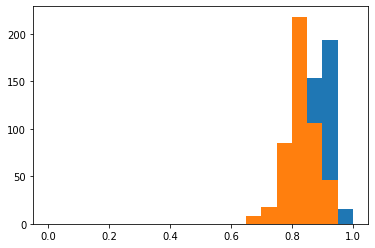

In [86]:
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
res = ttest_ind(bleu_trump[:,0], bleu_others[:,0], equal_var = False)
print(res)
plt.hist(bleu_trump[:,0], bins = 20, range = (0,1))
plt.hist(bleu_others[:,0], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=20.497708852405882, pvalue=7.783270801204307e-77)


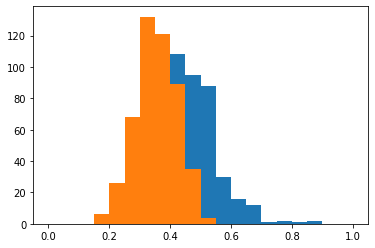

In [92]:
res = ttest_ind(bleu_trump[:,1], bleu_others[:,1], equal_var = False)
print(res)
plt.hist(bleu_trump[:,1], bins = 20, range = (0,1))
plt.hist(bleu_others[:,1], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=15.546875010513027, pvalue=4.094193281463203e-46)


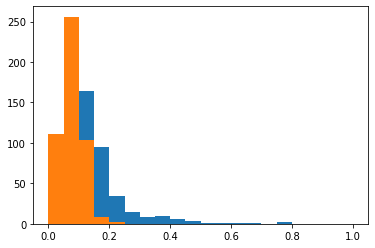

In [93]:
res = ttest_ind(bleu_trump[:,2], bleu_others[:,2], equal_var = False)
print(res)
plt.hist(bleu_trump[:,2], bins = 20, range = (0,1))
plt.hist(bleu_others[:,2], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=10.163760986618184, pvalue=3.22784678024537e-22)


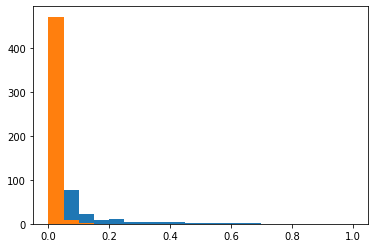

In [94]:
res = ttest_ind(bleu_trump[:,3], bleu_others[:,3], equal_var = False)
print(res)
plt.hist(bleu_trump[:,3], bins = 20, range = (0,1))
plt.hist(bleu_others[:,3], bins = 20, range = (0,1))
plt.show()

In [90]:
textclsTrue = Textclassifier.predict_proba(testset)[:,1]
POSclsTrue = Posclassifier.predict(testset)[:,1]

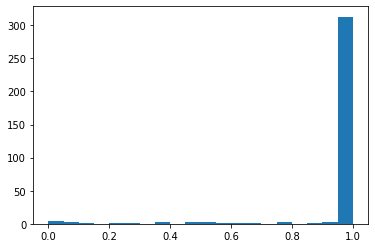

In [95]:
plt.hist(textclsTrue, bins = 20, range = (0,1))
plt.show()

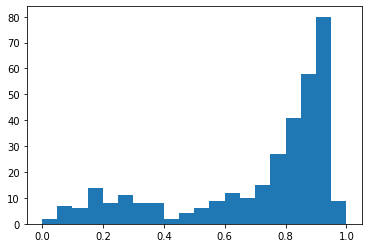

In [96]:
plt.hist(POSclsTrue, bins = 20, range = (0,1))
plt.show()

In [97]:
# lets generate 30 text samples 

In [120]:
grams_mem = formdb(tokens, 3)
samples = []

for i in range(100): 
    context = randcontext(gentrain,10)
    samples.append(generator(grams_mem, 130, context, temp = 1, k = 5, p = 0.4))

In [121]:
unnamedsamples = [unnameTextWithM(i) for i in samples]

In [122]:
bleu_gen = np.array([np.array(evaluate_bleu(testset, genstr)) for genstr in unnamedsamples])

In [123]:
textclsgen = Textclassifier.predict_proba(unnamedsamples)[:,1]
POSclsgen = Posclassifier.predict(unnamedsamples)[:,1]

Ttest_indResult(statistic=11.706154689167475, pvalue=6.175569733784975e-23)
Ttest_indResult(statistic=-0.26124923224878566, pvalue=0.7942167066673357)


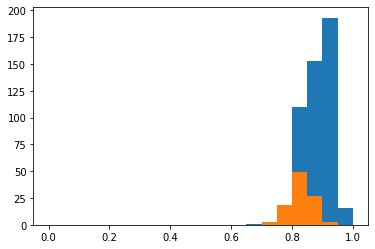

In [135]:
from scipy.stats import mannwhitneyu
res = ttest_ind(bleu_trump[:,0], bleu_gen[:,0], equal_var = False)
print(res)
res = ttest_ind(bleu_others[:,0], bleu_gen[:,0], equal_var = False)
print(res)
plt.hist(bleu_trump[:,0], bins = 20, range = (0,1))
plt.hist(bleu_gen[:,0], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=47.275498748378475, pvalue=1.5065454656842846e-150)
Ttest_indResult(statistic=32.93148019090212, pvalue=3.147287140179914e-89)


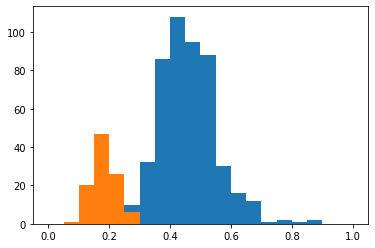

In [136]:
res = ttest_ind(bleu_trump[:,1], bleu_gen[:,1], equal_var = False)
print(res)
res = ttest_ind(bleu_others[:,1], bleu_gen[:,1], equal_var = False)
print(res)
plt.hist(bleu_trump[:,1], bins = 20, range = (0,1))
plt.hist(bleu_gen[:,1], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=25.104060066313576, pvalue=1.2359152716939415e-94)
Ttest_indResult(statistic=19.488541803014833, pvalue=4.441766568134973e-54)


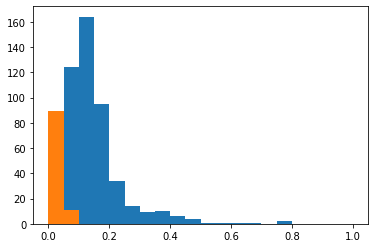

In [140]:
res = ttest_ind(bleu_trump[:,2], bleu_gen[:,2], equal_var = False)
print(res)
res = ttest_ind(bleu_others[:,2], bleu_gen[:,2], equal_var = False)
print(res)
plt.hist(bleu_trump[:,2], bins = 20, range = (0,1))
plt.hist(bleu_gen[:,2], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=10.998781260223495, pvalue=1.271054783200721e-25)
Ttest_indResult(statistic=3.4941760506297372, pvalue=0.0006256941347467985)


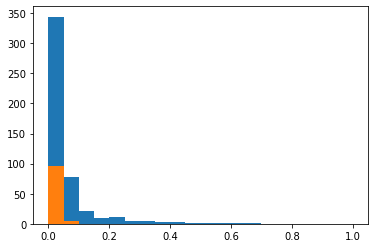

In [141]:
res = ttest_ind(bleu_trump[:,3], bleu_gen[:,3], equal_var = False)
print(res)
res = ttest_ind(bleu_others[:,3], bleu_gen[:,3], equal_var = False)
print(res)
plt.hist(bleu_trump[:,3], bins = 20, range = (0,1))
plt.hist(bleu_gen[:,3], bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=-4.364188662226434, pvalue=1.692758047858965e-05)
MannwhitneyuResult(statistic=15762.5, pvalue=0.16350795976752297)


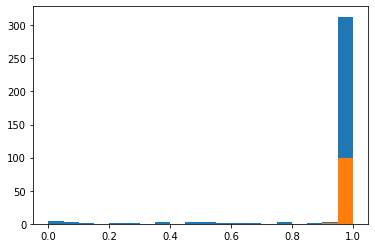

In [128]:
res = ttest_ind(textclsTrue, textclsgen, equal_var = False)
print(res)
res = mannwhitneyu(textclsTrue, textclsgen)
print(res)
plt.hist(textclsTrue, bins = 20, range = (0,1))
plt.hist(textclsgen, bins = 20, range = (0,1))
plt.show()

Ttest_indResult(statistic=-8.438566163315633, pvalue=6.076105129247122e-16)
MannwhitneyuResult(statistic=10913.0, pvalue=4.333698265372762e-08)


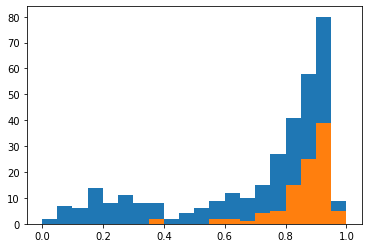

In [129]:
res = ttest_ind(POSclsTrue, POSclsgen, equal_var = False)
print(res)
res = mannwhitneyu(POSclsTrue, POSclsgen)
print(res)
plt.hist(POSclsTrue, bins = 20, range = (0,1))
plt.hist(POSclsgen, bins = 20, range = (0,1))
plt.show()